#Safety Classifier

The following is a neural network based safety classifier, that classifies the agent's actions as safety-critical or nominal, given the agent's state, goal,  and observations of the environment.

Built this with PyTorch and Numpy. Was in a little bit of a rush so didn't use JAX but might consider it down the line

Imports

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

Mount your drive for the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/Undergrad/University of Washington/Research/master_sim_data_filtered_augmented.npz"
data = np.load(file_path)

Extract the data

In [4]:
X_features_np = data['X_data_flat'].astype(np.float32)
y_labels_np = data['Y_labels_flat'].astype(np.int64)

print(f"Successfully loaded data from: {file_path}")
print(f"Total Samples: {X_features_np.shape[0]}")
print(f"Feature Dimension (State-Action): {X_features_np.shape[1]}")

Successfully loaded data from: /content/drive/MyDrive/Undergrad/University of Washington/Research/master_sim_data_filtered_augmented.npz
Total Samples: 8611
Feature Dimension (State-Action): 8


Split our data into training and testing (70/30)

In [5]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_features_np, y_labels_np,
    test_size=0.3,
    random_state=42,
    stratify=y_labels_np # makes sure data is balanced in the 70/30 splits
)

# converts to tensors
X_train = torch.from_numpy(X_train_np)
X_test = torch.from_numpy(X_test_np)
y_train = torch.from_numpy(y_train_np).unsqueeze(1)
y_test = torch.from_numpy(y_test_np).unsqueeze(1)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Input dimensions: {X_train.shape[1]}")

Training set size: 6027
Testing set size: 2584
Input dimensions: 8


## Neural network time!
To build this neural network, I chose the Multi-layer Perceptron (MLP) architecture. This is because it's very good with non-linear classification. It's a feed-forward NN, we are gonna feed the input layer through some hidden layers, with some non-linear functions and activation functions. Our output layer will output a scalar [0,1] for the classification.

In [6]:
class SafetyClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SafetyClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            # no sigmoid bc we use BCELossWithLogits which has built-in sigmoid
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SafetyClassifier(X_train.shape[1])

# Because we have imbalanced data, feed the weight of positives to BCELoss
positive_count = torch.sum(y_train)
negative_count = len(y_train) - positive_count
# Weight is (Negative Samples) / (Positive Samples)
pos_weight_value = negative_count / positive_count
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

print(f"\nCalculated Positive Class Weight: {pos_weight_value.item():.2f}")

# Define Loss, Optimizer, and DataLoader
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_data = TensorDataset(X_train, y_train.float())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
num_epochs = 30 # We really don't need much since our data is very predictable


Calculated Positive Class Weight: 1.33


Training time

As a note, precision is of the predicted safety-critical, how many were safety critical

In [17]:
train_losses = [] # List to store training losses

print("Starting training")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(X_batch) # sum weighted loss

    epoch_loss /= len(train_data) # calculate avg loss for the epoch
    train_losses.append(epoch_loss) # Store the avg loss

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {epoch_loss:.4f}')

# eval on test set
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test)
    # using threshold of 0.5, can play around with it
    y_pred_class = (y_pred_proba >= 0.5).int()

# convert tensors back to NumPy for sklearn metrics
y_test_np_flat = y_test.flatten().numpy()
y_pred_np_flat = y_pred_class.flatten().numpy()

# calculate metrics
accuracy = (y_pred_class == y_test.int()).sum().item() / len(y_test)
precision = precision_score(y_test_np_flat, y_pred_np_flat, zero_division=0)
recall = recall_score(y_test_np_flat, y_pred_np_flat, zero_division=0)
f1 = f1_score(y_test_np_flat, y_pred_np_flat, zero_division=0)

print("\nFinal Model Eval")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Starting training
Epoch [10/30], Average Training Loss: 0.0082
Epoch [20/30], Average Training Loss: 0.0077
Epoch [30/30], Average Training Loss: 0.0096

Final Model Eval
Test Accuracy: 99.77%


Some charts for the performance

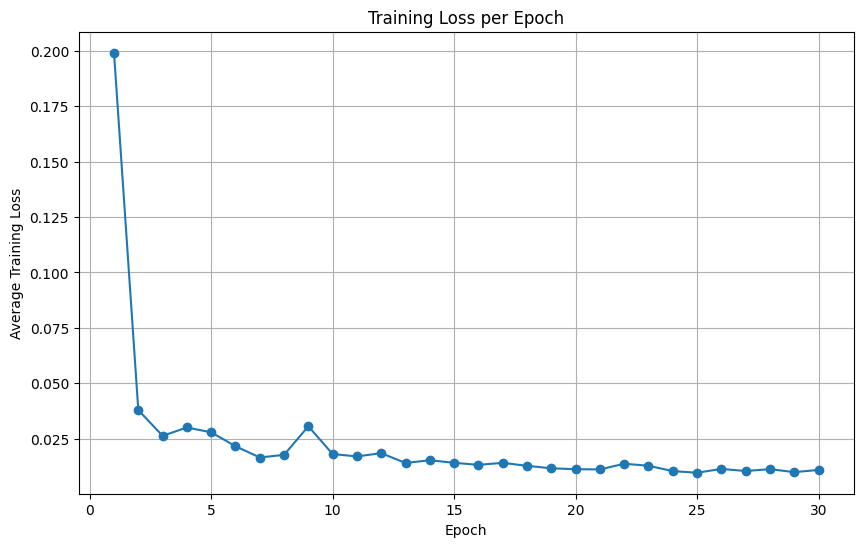

In [15]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.grid(True)
plt.show()

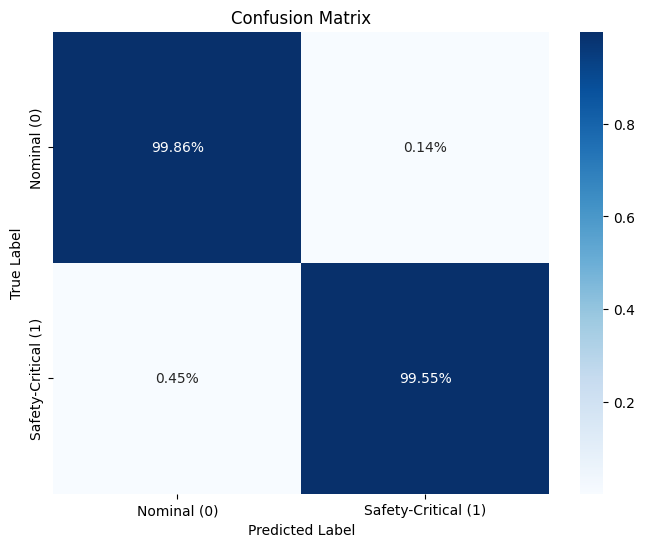

Confusion Matrix plot generated and saved as 'confusion_matrix.png'


<Figure size 640x480 with 0 Axes>

In [16]:
def plot_confusion_matrix(y_true, y_pred, labels=['Nominal (0)', 'Safety-Critical (1)']):

    # Calculate the confusion matrix
    # normalize='true' shows percentages per row (e.g., of all true critical states,
    # what percent were correctly predicted?)
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 6))

    # Use seaborn for a clear, heatmap visualization
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2%", # Format values as percentage with 2 decimals
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar=True
    )

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.savefig('confusion_matrix.png')
    print("Confusion Matrix plot generated and saved as 'confusion_matrix.png'")

# Run the plotting function
plot_confusion_matrix(y_test_np_flat, y_pred_np_flat)

## Summary

As we can see, we got very accurate results with this simple MLP classifier. We only have a 0.14% false positive, and 0.45% false negative. This is good because we don't want to label something as nominal when it is in fact safety critical.

Although we have good results, we must keep in mind that the data has very little to no noise and came from a controlled 2D Single Integrator environment. The next steps in this research is to extend this to noisy environments and then make use of computer vision to bring it to the real world.